In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using Distributed
@everywhere using Distributions
using Test
#using BenchmarkTools
using Dates

@everywhere struct Hack end
function fixRC()
    for p in workers()
        @fetchfrom p Hack()
    end
end
fixRC()

@everywhere src_path = "/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Source/Grid/"
#@everywhere src_path = "/cluster/home/fredrkro/mc/Source/Grid/"
out_path = "/home/nicolai/mc/Scripts/"
#out_path = "/cluster/home/fredrkro/mc/Data/ExperimentalRuns/"
staging_path = ""
#staging_path = "/cluster/home/fredrkro/Staging/"
@everywhere push!(LOAD_PATH, $src_path)
@everywhere using CuboidModule

@everywhere include(src_path*"observables.jl")
@everywhere include(src_path*"utilities.jl")

using JLD

In [3]:
# Enter data directory for structure function
fixRC()
# We run a simulation with parameter ν supplied by script
if length(ARGS) != 1
    println("ERROR: Need g supplied as script argument.")
    exit(-1)
end
ν = 0.0         # Gauge coupling
gs = [0.3]#[-0.5, 0.0, 0.3, 0.5, 0.7]         # Fermi surface anisotropy
κ₅ = 1.0

# TODO: We should probably benchmark vortexSnapshot and see that it is faster than mcSweeps
# Other parameters
M_est = 2^7  # Number of MC-steps to do at T_start before cooldown.
M_col = 2^18 # Number of MC-steps to use for cooling down the systems
N_steps = 2^10   # Number of temperatures to go through from high temp before reaching the final temperature. (will divide M_col) must be >= 2
M_th = 2^18  # Number of MC-steps to do for thermalization.
M = 2^12     # Number of measurements
M_amp = 15   # Number of these measurements that will be amplitude measurements, i.e. we need M >= M_amp
Δt = 2^6      # Number of MC-steps between each measurement
# L is assumed to be even.
L = 32     # System length
L₁ = L
L₂ = L
L₃ = L
split = (1,1,3)
N = L₁*L₂*L₃
# Specify extended landau gauge using n,m s.t. constant Aᵢ(Lⱼ+1) = Aᵢ(0) mod 2π
# n | L₁ and m | L₂
n = 0; m = 0
f = n/L₁ - m/L₂
T = 0.7
T_start = 2*4.0+0.1   # Start-temperature of states when thermalizing. 
N_g = length(gs)


# Print parameters
println("\nStarted script at: $(Dates.format(now(), "HH:MM"))")
println("Target temp: $(T)")
println("f = $(f)")
println("n = $(n)")
println("m = $(m)")
println("L = $(L)")
println("ν = $(ν)")
println("κ₅ = $(κ₅)")
println("gs = $(gs)")
if f < 0
    println("Number of anti-vortices: $(-f*L₁*L₂)")
else
    println("Number of vortices: $(f*L₁*L₂)")
end



Started script at: 17:50
Target temp: 1.5
f = 0.0
n = 0
m = 0
L = 32
ν = 0.0
κ₅ = 1.0
gs = [0.3]
Number of vortices: 0.0


In [4]:
# Checking available workers
workers_pr_state = Int(split[1]*split[2]*split[3])
needed_workers = workers_pr_state*N_g
if nprocs()-1 < needed_workers
    println("ERROR: Only $(nprocs()-1) workers have been allocated. $(needed_workers) are needed to split all
of the $(length(gs)) states into $(split[1]*split[2]*split[3]) subcuboids.")
    exit()
end

In [5]:
syst = SystConstants(L₁,L₂,L₃,1/gs[1]^2,ν,κ₅,n,m)
cub = Cuboid(6, syst, split, 1/T_start; u⁺=1/√(2), u⁻=1/√(2), pid_start=2)
setUpdates!(cub; θ_max = 3.13, u_max = 1.0/√(2), A_max = 1e-1);

In [8]:
nMCS!(cub, 1000)

# Checking acceptance rates

In [21]:
n = 20
A_checks = [(20/3e-3)^(i/(n-1))*3e-3 for i = 0:n-1]
ARs = Array{Float64, 1}(undef, n)
ARs_err = Array{Float64, 1}(undef, n)
θ_max = 3.14; u_max = 1.0/√(2)
@time for i = 1:length(A_checks)
    setUpdates!(cub; θ_max = θ_max, u_max = u_max, A_max = A_checks[i])
    ARs[i], ARs_err[i] = estimateAR!(cub)
end

676.812412 seconds (25.74 M allocations: 823.282 MiB, 0.12% gc time)


In [13]:
plt = plot(A_checks, ARs.*100; yerror=ARs_err.*100, xaxis=:log, 
    title="Acceptance Rate vs. A_max", xlabel="A_max", ylabel="AR %", label="θ_max = $(θ_max),\n u_max = $(round(u_max; digits=3))")
savefig(plt, "AR_vs_Amax.png")

#### $\theta$ acceptance rates

In [9]:
n_ch = 20
#θ_checks = [(π/3e-3)^(i/(n-1))*3e-3 for i = 0:n_ch-1]
θ_checks = collect(range(0.1, 5; length=n_ch))
#A_checks_lin = collect(range(0.05, 10; length=n_ch))
ARs_θ = Array{Float64, 1}(undef, n_ch)
ARs_θ_err = Array{Float64, 1}(undef, n_ch)
θ_max = 3.14; u_max = 1.0/√(2); A_max = 0.6
@time for i = 1:length(θ_checks)
    setUpdates!(cub; θ_max = θ_checks[i], u_max = u_max, A_max = A_max)
    ARs_θ[i], ARs_θ_err[i] = estimateAR!(cub)
end

659.710964 seconds (25.72 M allocations: 827.162 MiB, 0.11% gc time)


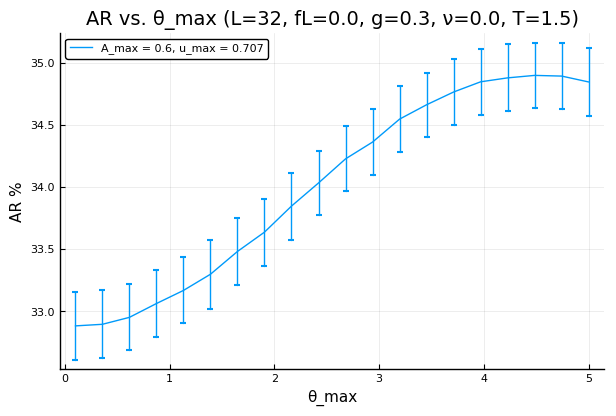

In [12]:
plt = plot(θ_checks, ARs_θ.*100; yerror=ARs_θ_err.*100, 
    title="AR vs. θ_max (L=$(L), fL=$(f*L), g=$(gs[1]), ν=$(ν), T=$(T))", xlabel="θ_max", ylabel="AR %",
    label="A_max = $(A_max), u_max = $(round(u_max; digits=3))")
savefig(plt, "AR_vs_theta_A=0.6.png")

In [13]:
sc = fetch(cub.grid[1])
θ_rng = sc.sim.θ_rng

0.47990098763802447

In [38]:
rand(θ_rng)

-4.812677660328159

In [77]:
mod(rand(θ_rng), 2π)-π

-0.4548666478806562